<a href="https://colab.research.google.com/github/isabhass/teste/blob/main/BackTestingCarteiraComBT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Vamos comparar duas estratégias - Rebalanceamento de Buy&Hold

Video do canal Código Quant - BackTesting de Carteira com Python (BT)

In [ ]:
!pip install bt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 20.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bt: filename=bt-0.2.9-cp39-cp39-linux_x86_64.whl size=1188192 sha256=3d28576b5c16f8c14e29521d97faa2d62dcdabc6bef967c7ebd9dca0acf36cb9
  Stored in directory: /root/.cache/pip/wheels/94/27/2d/9d6f4170a0a76f7b431cc3008624c6b4221eb7221d85076e1b
Successfully built bt


In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import bt
import yfinance as yf

import pandas as pd
import matplotlib
matplotlib.style.use('seaborn-darkgrid')
%matplotlib inline

<ipython-input-3-1dc368253006>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn-darkgrid')


## Funções

In [ ]:
def consulta_bc(codigo_bcb):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

In [ ]:
def cdi_acumulado(data_inicio, data_fim):
  cdi = consulta_bc(12)
  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

In [ ]:
data_inicio = '2018-01-02'
data_fim = '2023-03-25'

In [ ]:
cdi = cdi_acumulado(data_inicio=data_inicio, data_fim=data_fim)

In [ ]:
tickers_carteira = ['^GSPC', 'BTC-USD']

In [ ]:
carteira = yf.download(tickers_carteira, start=data_inicio, end=data_fim)['Adj Close']

[*********************100%***********************]  2 of 2 completed


In [ ]:
carteira['renda_fixa'] = cdi
carteira.dropna(inplace=True)

In [ ]:
carteira

,BTC-USD,^GSPC,renda_fixa
Date,,,
2018-01-02,14982.099609,2695.810059,1.000000
2018-01-03,15201.000000,2713.060059,1.000529
2018-01-04,15599.200195,2723.989990,1.000794
2018-01-05,17429.500000,2743.149902,1.001058
2018-01-08,15170.099609,2747.709961,1.001323
...,...,...,...
2023-03-17,27423.929688,3916.639893,1.397020
2023-03-20,27767.236328,3951.570068,1.397729
2023-03-21,28175.816406,4002.870117,1.398439


In [ ]:
rebalanceamento = bt.Strategy('rebalanceamento', 
                [bt.algos.RunMonthly(run_on_end_of_period=True),
                 bt.algos.SelectAll(),
                 bt.algos.WeighEqually(),
                 bt.algos.Rebalance()])

In [ ]:
buy_hold = bt.Strategy('Buy&Hold', 
                   [ bt.algos.RunOnce(),
                     bt.algos.SelectAll(),
                     bt.algos.WeighEqually(),
                     bt.algos.Rebalance()]
                    )

In [ ]:
bt1 = bt.Backtest(rebalanceamento, carteira)
bt2 = bt.Backtest(buy_hold, carteira)

In [ ]:
resultados = bt.run(bt1, bt2)

## Rsultados

In [ ]:
resultados.display()

Stat                 rebalanceamento    Buy&Hold
-------------------  -----------------  ----------
Start                2018-01-01         2018-01-01
End                  2023-03-23         2023-03-23
Risk-free rate       0.00%              0.00%

Total Return         120.44%            58.11%
Daily Sharpe         0.71               0.46
Daily Sortino        1.13               0.72
CAGR                 16.35%             9.17%
Max Drawdown         -37.59%            -48.92%
Calmar Ratio         0.43               0.19

MTD                  7.44%              7.88%
3m                   22.68%             21.62%
6m                   20.90%             19.56%
YTD                  23.09%             21.97%
1Y                   -7.46%             -17.19%
3Y (ann.)            36.06%             25.45%
5Y (ann.)            20.97%             13.02%
10Y (ann.)           -                  -
Since Incep. (ann.)  16.35%             9.17%

Daily Sharpe         0.71               0.46
Daily Sorti

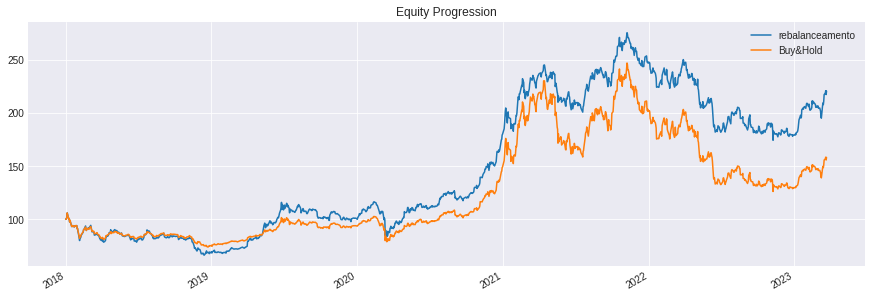

In [ ]:
resultados.plot();

## Operações

In [ ]:
resultados.get_transactions()

price  quantity
Date       Security                          
2018-01-02 BTC-USD     14982.099609      22.0
           ^GSPC        2695.810059     123.0
           renda_fixa      1.000000  333333.0
2018-01-31 BTC-USD     10221.099609       7.0
           ^GSPC        2823.810059     -16.0
...                             ...       ...
2023-01-31 BTC-USD     23139.283203      -6.0
           ^GSPC        4076.600098      13.0
           renda_fixa      1.375202   61112.0
2023-02-28 ^GSPC        3970.149902       4.0
           renda_fixa      1.387829   -7272.0

[177 rows x 2 columns]

Pesos

In [ ]:
resultados.get_security_weights()

,BTC-USD,^GSPC,renda_fixa
2018-01-01,0.000000,0.000000,0.000000
2018-01-02,0.329606,0.331585,0.333333
2018-01-03,0.332060,0.331349,0.331154
2018-01-04,0.337344,0.329351,0.327922
2018-01-05,0.361738,0.318303,0.314792
...,...,...,...
2023-03-17,0.366314,0.310290,0.317096
2023-03-20,0.368134,0.310723,0.314891
2023-03-21,0.369995,0.311760,0.312052
2023-03-22,0.364562,0.311733,0.317408


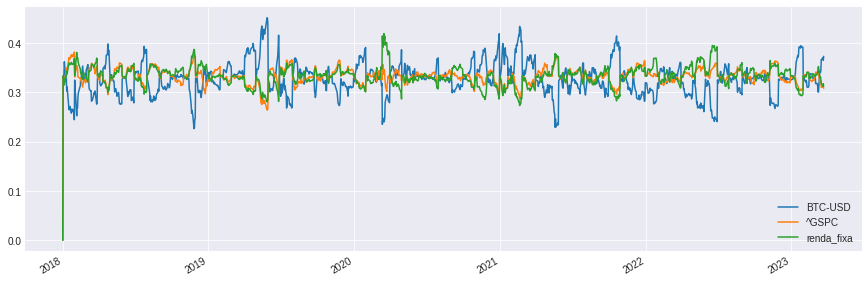

In [ ]:
resultados.plot_security_weights()